In [1]:
# !conda install -c conda-forge folium=0.5.0 --yes 
# uncomment above line if you haven't completed the Foursquare API lab

In [1]:
import requests
import numpy as np
import pandas as pd
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

# 1. Get restaurants data from Foursquare and show them by folium map

In [5]:
######
# The function is to setup the Foursquare account, the search key words, the search radius and the position by 
# latitude and longitude. It returns a pandas dataframe which only have clean data we will use in the folium map.
######
def json2dataframe(search_query = 'supermarket', radius = 5000, latitude = -33.8632, longitude = 151.2032):
    # setup my Foursquare developer account 
    CLIENT_ID = 'RT41XXZJW14HIVNPCZCEKFMZYDA5FIQVJWPGMQD4PRI40BAL' # your Foursquare ID
    CLIENT_SECRET = 'ILXHXDF4WO5WOWO2EIV20O0O4FYRKYJKOSPLSIVPCH4RF3Z5' # your Foursquare Secret
    VERSION = '20190204'
    LIMIT = 50
    # setup search conditions
    search_query = search_query
    print(search_query + ' .... OK!')

    # Define the corresponding URL
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

    # Send the GET Request and examine the results
    results = requests.get(url).json()

    # Get relevant part of JSON and transform it into a pandas dataframe
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)

    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    return dataframe_filtered

In [6]:
# The geograpical coordinate of Sydney
latitude = -33.8632
longitude = 151.2032

In [7]:
# setup search_query as Asia restaurants and Italian restaurants
search_1 = json2dataframe(search_query = 'Asia restaurant', radius = 10000)
search_2 = json2dataframe(search_query = 'Italian restaurant', radius = 10000)

Asia restaurant .... OK!
Italian restaurant .... OK!


In [8]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel
# add results as circle markers with different color
results = [[search_1, 'red'], [search_2,'blue']]
for ele in results:
    dataframe_filtered = ele[0]
    color = ele[1]
    for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color=color,
            popup=label,
            fill = True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(venues_map)

# display map. This map shows the distribution of Asia restaurants (red circle marker) and 
# Italian restaurants (blue circle marker)
venues_map
# this map may be not shown in github. Please see the report in detail.

# 2. Get the overall rating, the number of tips of all restaurants from Foursquare. Then cluster them using k-means

In [9]:
2. # setup search_query as school
restaurants = json2dataframe(search_query = 'restaurant', radius = 10000)

restaurant .... OK!


In [10]:
restaurants

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Art Gallery of NSW Restaurant,Café,"Art Gallery of NSW, Ground Floor",AU,Sydney,Australia,Art Gallery Rd.,1430,"[Art Gallery of NSW, Ground Floor (Art Gallery...","[{u'lat': -33.868780515, u'lng': 151.217141047...",-33.868781,151.217141,The Domain,2000,NSW,4bc57e820a30d13a401a5a9c
1,The Gantry Restaurant & Bar,Hotel Bar,11 Hickson Rd,AU,Sydney,Australia,NaN,1086,"[11 Hickson Rd, Sydney NSW 2000, Australia]","[{u'lat': -33.8542833393, u'lng': 151.20798971...",-33.854283,151.207990,Walsh BayCentral Business District,2000,NSW,4b05875ff964a520818e22e3
2,Condor Japanese Noodle Restaurant,Noodle House,5 York St.,AU,Sydney,Australia,Jamison St.,244,"[5 York St. (Jamison St.), Sydney NSW 2000, Au...","[{u'lat': -33.864462, u'lng': 151.205366, u'la...",-33.864462,151.205366,NaN,2000,NSW,4ba8126ef964a520a3ca39e3
3,Saké Restaurant & Bar,Japanese Restaurant,12 Argyle St,AU,Sydney,Australia,NaN,633,"[12 Argyle St, Sydney NSW 2000, Australia]","[{u'lat': -33.8589608325, u'lng': 151.20776502...",-33.858961,151.207765,NaN,2000,NSW,4b38a445f964a5201e4f25e3
4,Palace Chinese Restaurant,Dim Sum Restaurant,38/133-148 Castlereagh St,AU,Sydney,Australia,NaN,1089,"[38/133-148 Castlereagh St, Sydney NSW 2000, A...","[{u'lat': -33.8716113617, u'lng': 151.20922297...",-33.871611,151.209223,NaN,2000,NSW,4b7f4966f964a520002530e3
5,The Restaurant Pendolino,Italian Restaurant,"Shop 100, 412-414 George St.",AU,Sydney,Australia,in The Strand Arcade,776,"[Shop 100, 412-414 George St. (in The Strand A...","[{u'lat': -33.8693397617, u'lng': 151.20718648...",-33.869340,151.207186,NaN,2000,NSW,4b85fe3bf964a520d77c31e3
6,Blue Fish Seafood Restaurant,Seafood Restaurant,Harbourside Shopping Centre,AU,Darling Harbour,Australia,NaN,965,"[Harbourside Shopping Centre, Darling Harbour ...","[{u'lat': -33.8712350668, u'lng': 151.19926573...",-33.871235,151.199266,NaN,2000,NSW,4b2463e7f964a520f26624e3
7,Olivo Restaurant,Italian Restaurant,"Shop 295-297, 2 Darling Drive",AU,Darling Harbour,Australia,in Harbourside Shopping Centre,1008,"[Shop 295-297, 2 Darling Drive (in Harbourside...","[{u'lat': -33.871655747, u'lng': 151.199282367...",-33.871656,151.199282,NaN,2000,NSW,5208ac6c498eaeeaa83df615
8,Zilver Restaurant,Chinese Restaurant,477 Pitt St,AU,Haymarket,Australia,at Hay St,1914,"[477 Pitt St (at Hay St), Haymarket NSW 2000, ...","[{u'lat': -33.8801834531, u'lng': 151.20648884...",-33.880183,151.206489,Sydney,2000,NSW,4b058766f964a520729022e3
9,Sakuratei Japanese Restaurant (桜亭),Japanese Restaurant,202 Clarence St,AU,Sydney,Australia,Market St,954,"[202 Clarence St (Market St), Sydney NSW 2000,...","[{u'lat': -33.8715149787, u'lng': 151.20571737...",-33.871515,151.205717,NaN,2000,NSW,4b3afd46f964a520307025e3


In [11]:
####
# This function is used to extract rating and tips information based on venue_id from Foursquare
def rating(venue_id):
    CLIENT_ID = 'RT41XXZJW14HIVNPCZCEKFMZYDA5FIQVJWPGMQD4PRI40BAL' # your Foursquare ID
    CLIENT_SECRET = 'ILXHXDF4WO5WOWO2EIV20O0O4FYRKYJKOSPLSIVPCH4RF3Z5' # your Foursquare Secret
    VERSION = '20190204'
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        #print(result['response']['venue']['rating'], result['response']['venue']['tips']['count'])
        return result['response']['venue']['rating'], result['response']['venue']['tips']['count']
    except:
        #print('This venue has not been rated yet.')
        return 5.0, 0

In [12]:
# Get the overall rating, the number of tips of all restaurant
restaurants['rating'] = 0
restaurants['tips'] = 0
for idx, venue_id in enumerate(restaurants['id'].values):
    restaurants.iloc[idx,-2], restaurants.iloc[idx,-1] = rating(venue_id = venue_id)

In [19]:
restaurants.iloc[0,1] = 'cafe'

In [22]:
df = restaurants.copy()

In [24]:
df.columns.values

array(['name', 'categories', u'address', u'cc', u'city', u'country',
       u'crossStreet', u'distance', u'formattedAddress',
       u'labeledLatLngs', u'lat', u'lng', u'neighborhood', u'postalCode',
       u'state', 'id', 'rating', 'tips'], dtype=object)

In [38]:
restaurants[['categories', 'lat', 'lng', 'neighborhood',  'postalCode', 'id', 'rating', 'tips']].to_csv('restaurants.csv')

### k-means cluster

In [39]:
restaurants_clustering = restaurants[['rating', 'tips']].values
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_clustering)
# check cluster labels generated for each row in the dataframe
restaurants['label'] = kmeans.labels_

In [49]:
temp = restaurants.groupby('label')['name'].apply(lambda x: "%s" % ', '.join(x))

In [61]:
pd.DataFrame(temp).reset_index(level=0).values

array([[0,
        u"Art Gallery of NSW Restaurant, The Gantry Restaurant & Bar, Condor Japanese Noodle Restaurant, Olivo Restaurant, North Ocean Chinese Restaurant, The Gallery Restaurant & Bar, The Hudson Restaurant & Bar, Cellini's Cafe Bar and Restaurant, Garden Court Restaurant, Postales Spanish Restaurant and Tapas Bar, Fideli's Bar and Restaurant, Esperanto Restaurant, Kao Kao Korean Restaurant, Jordons Seafood Restaurant, nel. restaurant, Felix Restaurant, Altitude Restaurant, Arisan Chinese Restaurant, Hellenic Club Restaurant, Haymarket Restaurant, Sphere Restaurant, Spicy Szechuan Restaurant, Royal Pavilion Seafood Restaurant \u7687\u5ead\u96c5\u805a, Takeru Japanese Restaurant"],
       [1,
        u"The Restaurant Pendolino, Zilver Restaurant, NaruOne Korean Restaurant, The Eight Modern Chinese Restaurant, Superbowl Chinese Restaurant, Bill And Toni's Italian Restaurant"],
       [2,
        u"Palace Chinese Restaurant, Blue Fish Seafood Restaurant, Sakuratei Japanese Rest

### Finally, let's visualize the resulting clusters

In [40]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [41]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the Conrad Hotel
# add results as circle markers with different color
results = [restaurants]
for ele in results:
    dataframe_filtered = ele
    for lat, lng, label, cluster in zip(dataframe_filtered.lat, dataframe_filtered.lng,
                                         dataframe_filtered.categories, dataframe_filtered.label):
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color=rainbow[cluster-1],
            popup=label,
            fill = True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.6
        ).add_to(venues_map)

# display map. This map shows the distribution of Asia restaurants (red circle marker) and 
# Italian restaurants (blue circle marker)
venues_map
# this map may be not shown in github. Please see the report in detail.

# 3. Explore the climate data of Sydney

In [53]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [54]:
# the climate data of Sydney is obtained from http://www.bom.gov.au
# The Bureau of Meteorology is Australia's national weather, climate and water agency. 
df = pd.read_csv("Sydney_climate_record.csv")

In [55]:
# Mean maximum and minimum temperature (Degrees C) for years 1859 to 2018
t_max = df.iloc[0,1:13].astype('float')
t_min = df.iloc[10,1:13].astype('float')

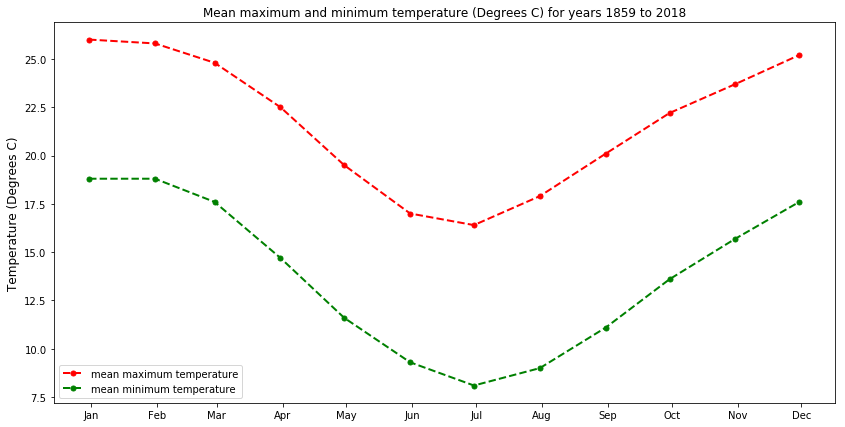

In [56]:
fig, ax = plt.subplots(figsize=(14, 7))
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
x = pd.date_range('2000-12-01', '2001-12-1 23:00', freq='M')

ax.plot(x,t_max, color='red', marker='o', linestyle='dashed',
        linewidth=2, markersize=5, label = 'mean maximum temperature')
ax.plot(x,t_min, color='green', marker='o', linestyle='dashed',
        linewidth=2, markersize=5, label = 'mean minimum temperature')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax.legend()
plt.ylabel('Temperature (Degrees C)', fontsize = 12)
plt.title('Mean maximum and minimum temperature (Degrees C) for years 1859 to 2018', fontsize = 12)
plt.show()

In [57]:
fig.savefig('temperature.png')

In [58]:
#Mean rainfall (mm) for years 1858 to 2019
rain = df.iloc[23,1:13].astype('float')

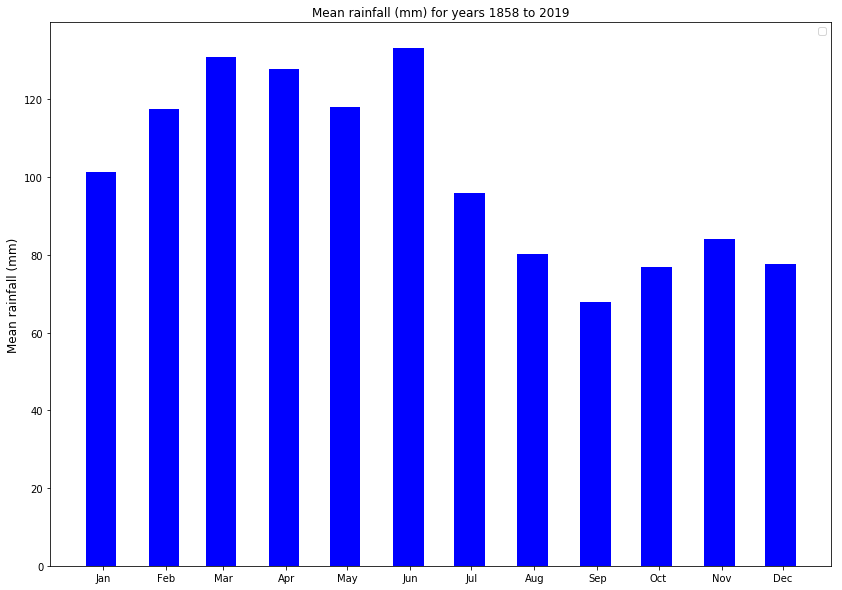

In [59]:
fig, ax = plt.subplots(figsize=(14, 10))
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
x = pd.date_range('2000-12-01', '2001-12-1 23:00', freq='M')

ax.bar(x,rain, width = 15, color='blue')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax.legend()
plt.ylabel('Mean rainfall (mm)', fontsize = 12)
plt.title('Mean rainfall (mm) for years 1858 to 2019', fontsize = 12)
plt.show()

In [60]:
fig.savefig('rainfall.png')

In [ ]:
df